# decode some test sentences

save as a csv file for reading

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Model, Sequential, model_from_json
from keras.models import load_model
from keras.layers.wrappers import Bidirectional
from keras.layers import Activation, Merge, average, concatenate, Input, TimeDistributed, LSTM, Dense, Dropout, Embedding
from keras.models import save_model, load_model
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils

/home/derek/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# restrict GPU usage here
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# load data
print("loading data...\n")
word2idx = np.load('encoded/word2idx.npy').item()
idx2word = np.load('encoded/idx2word.npy').item()
pos2idx = np.load('encoded/pos2idx.npy').item()
idx2pos = np.load('encoded/idx2pos.npy').item()
ner2idx = np.load('encoded/ner2idx.npy').item()
idx2ner = np.load('encoded/idx2ner.npy').item()
test_idx = np.load('encoded/test_idx.npy')
X_test_sents = np.load('encoded/X_test_sents.npy')
X_test_pos = np.load('encoded/X_test_pos.npy')
y_test_ner = np.load('encoded/y_test_ner.npy')
print("...data loaded!")

loading data...

...data loaded!


## load weights

load it this way because of `keras-contrib` CRF layer

In [4]:
# params
MAX_LENGTH = 30
MAX_VOCAB = 25000    # see preprocessing.ipynb
WORDEMBED_SIZE = 300 # see data_preprocessing.ipynb
POS_EMBED_SIZE = 100 # see data_preprocessing.ipynb
HIDDEN_SIZE = 400    # LSTM Nodes/Features/Dimension
DROPOUTRATE = 0.25
TAG_VOCAB = len(list(idx2pos.keys()))
NER_VOCAB = len(list(idx2ner.keys()))

print('Building model...\n')

# define model

# text layers : dense embedding > dropout > bi-LSTM
txt_input = Input(shape=(MAX_LENGTH,), name='txt_input')
txt_embed = Embedding(MAX_VOCAB, WORDEMBED_SIZE, input_length=MAX_LENGTH,
                      name='txt_embedding', trainable=True, mask_zero=True)(txt_input)
txt_drpot = Dropout(DROPOUTRATE, name='txt_dropout')(txt_embed)

# pos layers : dense embedding > dropout > bi-LSTM
pos_input = Input(shape=(MAX_LENGTH,), name='pos_input')
pos_embed = Embedding(TAG_VOCAB, POS_EMBED_SIZE, input_length=MAX_LENGTH,
                      name='pos_embedding', trainable=True, mask_zero=True)(pos_input)
pos_drpot = Dropout(DROPOUTRATE, name='pos_dropout')(pos_embed)

# merged layers : merge (concat, average...) word and pos > bi-LSTM > bi-LSTM
mrg_cncat = concatenate([txt_drpot, pos_drpot], axis=2)
mrg_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='mrg_bidirectional_1')(mrg_cncat)

# extra LSTM layer, if wanted
mrg_drpot = Dropout(DROPOUTRATE, name='mrg_dropout')(mrg_lstml)
mrg_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='mrg_bidirectional_2')(mrg_lstml)


# final linear chain CRF layer
crf = CRF(NER_VOCAB, sparse_target=True)
mrg_chain = crf(mrg_lstml)

model = Model(inputs=[txt_input, pos_input], outputs=mrg_chain)

Building model...



In [5]:
# load model
save_load_utils.load_all_weights(model,'model/crf_model.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
txt_input (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
pos_input (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
txt_embedding (Embedding)       (None, 30, 300)      7500000     txt_input[0][0]                  
__________________________________________________________________________________________________
pos_embedding (Embedding)       (None, 30, 100)      4200        pos_input[0][0]                  
__________________________________________________________________________________________________
txt_dropou

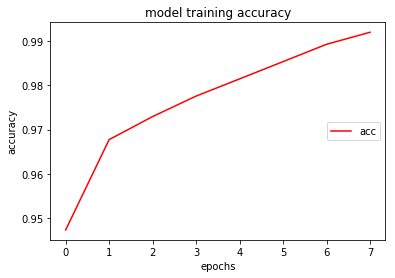

In [6]:
# load history dict from training
hist_dict = np.load('model/hist_dict.npy').item()
plt.plot(hist_dict['acc'], 'red', label='acc')
# if using 'validation_size' in .fit()
# plt.plot(hist_dict['val_acc'], 'blue', label='val_acc')
plt.title("model training accuracy")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc=7)
plt.show()

In [7]:
decoded = []
for sent_idx in range(len(X_test_sents[:500])):
    
    this_txt = sequence.pad_sequences([X_test_sents[sent_idx]], maxlen=MAX_LENGTH, truncating='post', padding='post')
    this_pos = sequence.pad_sequences([X_test_pos[sent_idx]], maxlen=MAX_LENGTH, truncating='post', padding='post')
    this_pred = model.predict([this_txt, this_pos])
    this_pred = [np.argmax(p) for p in this_pred[0]]
    np.shape(this_pred)

    word, pos, tru, prd = [], [], [], []

    # for each word in the sentence...
    for idx, wordid in enumerate(X_test_sents[sent_idx][:len(this_pred)]):

        # decode word
        word.append(idx2word[wordid])
        # decode pos
        pos.append(idx2pos[X_test_pos[sent_idx][idx]])
        # decode true NER tag
        tru.append(idx2ner[y_test_ner[sent_idx][idx]])
        # decode prediction
        prd.append(idx2ner[this_pred[idx]])

    answ = pd.DataFrame(
    {
        'word': word,
        'pos': pos,
        'true': tru,
        'pred': prd,
        'skip' : [' ' for s in word]
    })
    answ = answ[['word', 'pos', 'true', 'pred', 'skip']]
    answ = answ.T
    decoded.append(answ)

In [8]:
result = pd.concat(decoded)

In [9]:
result.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
word,the,post,became,vacant,in,october,",",when,former,costa,...,at,home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos,DT,NN,VBD,JJ,IN,NNP,",",WRB,JJ,NNP,...,IN,NN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
true,O,O,O,O,O,B-tim,O,O,O,O,...,O,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pred,O,O,O,O,O,B-tim,O,O,O,B-geo,...,O,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
skip,,,,,,,,,,,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
result.to_csv('results/keras-biLSTM-CRF_sample.csv')